Number of contours detected: 35
Detected hair widths (in pixels): [22, 60, 5, 8, 114, 213, 4, 8, 5, 4, 14, 6, 13, 47, 17, 4, 203, 15, 10, 3, 6, 5, 6, 254, 3, 228, 249, 65, 81, 13, 9, 92, 36, 137, 293]
Detected hair widths (in mm): [0.572, 1.5599999999999998, 0.13, 0.208, 2.964, 5.537999999999999, 0.104, 0.208, 0.13, 0.104, 0.364, 0.156, 0.33799999999999997, 1.222, 0.442, 0.104, 5.278, 0.38999999999999996, 0.26, 0.078, 0.156, 0.13, 0.156, 6.604, 0.078, 5.928, 6.473999999999999, 1.69, 2.106, 0.33799999999999997, 0.23399999999999999, 2.392, 0.9359999999999999, 3.562, 7.617999999999999]


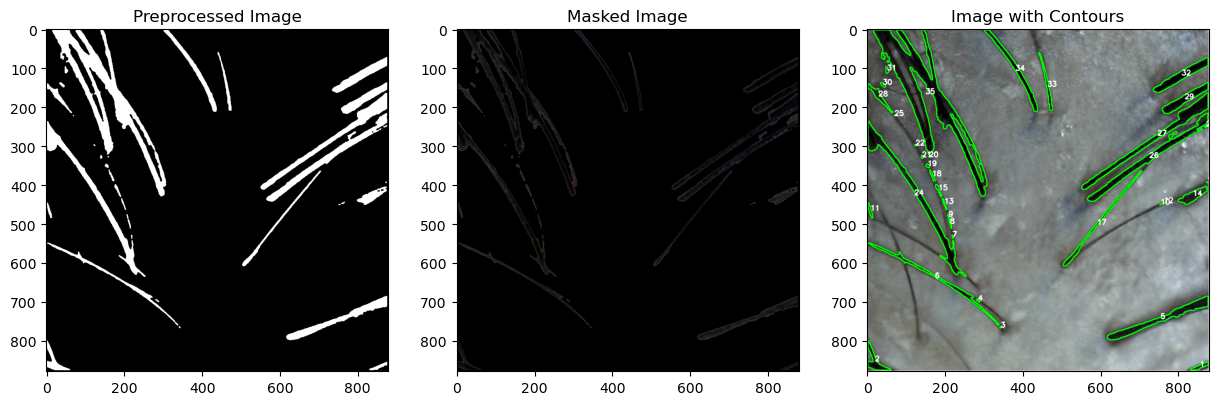

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def preprocess_and_mask(image_path):
    img = cv2.imread(image_path)
    
    if img is None:
        raise ValueError(f"Image at path {image_path} could not be loaded.")
    
    # PRE-PROCESSING
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Gaussian blur 
    blurred_img = cv2.GaussianBlur(img_gray, (5, 5), 0)
    
    # Binary thresholding
    _, thresh_img = cv2.threshold(blurred_img, 50, 255, cv2.THRESH_BINARY_INV)
    
    kernel = np.ones((3, 3), np.uint8) 
    morph_img = cv2.morphologyEx(thresh_img, cv2.MORPH_CLOSE, kernel)
    morph_img = cv2.morphologyEx(morph_img, cv2.MORPH_OPEN, kernel)
    
    # Masking 
    masked_img = cv2.bitwise_and(img, img, mask=morph_img)
    
    return morph_img, masked_img, img

def calculate_widths(preprocessed_img):
    # Find contours in the preprocessed image
    contours, _ = cv2.findContours(preprocessed_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    widths = []
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        width = min(w, h)  # Use the smaller dimension as the width
        widths.append(width)
    
    return widths, contours

def convert_pixels_to_mm(widths, pixel_to_mm_ratio):
    return [width * pixel_to_mm_ratio for width in widths]

def main(image_path):
    preprocessed_img, masked_img, original_img = preprocess_and_mask(image_path)
    
    widths_pixels, contours = calculate_widths(preprocessed_img)
    
    print(f"Number of contours detected: {len(contours)}")
    
    pixel_to_mm_ratio = 0.026 
    widths_mm = convert_pixels_to_mm(widths_pixels, pixel_to_mm_ratio)
    
    print(f"Detected hair widths (in pixels): {widths_pixels}")
    print(f"Detected hair widths (in mm): {widths_mm}")
    
    img_with_contours = original_img.copy()
    cv2.drawContours(img_with_contours, contours, -1, (0, 255, 0), 2)
    
    for i, contour in enumerate(contours):
        # Calculate the center of the contour
        M = cv2.moments(contour)
        if M["m00"] != 0:
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
        else:
            cX, cY = contour[0][0]
        
        cv2.putText(img_with_contours, str(i + 1), (cX, cY), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)
    
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.title('Preprocessed Image')
    plt.imshow(preprocessed_img, cmap='gray')
    
    plt.subplot(1, 3, 2)
    plt.title('Masked Image')
    plt.imshow(cv2.cvtColor(masked_img, cv2.COLOR_BGR2RGB))
    
    plt.subplot(1, 3, 3)
    plt.title('Image with Contours')
    plt.imshow(cv2.cvtColor(img_with_contours, cv2.COLOR_BGR2RGB))
    
    plt.show()

main('C:/Users/arthi/Downloads/WhatsApp Image 2024-08-07 at 8.34.24 PM.jpeg')
